<a href="https://colab.research.google.com/github/ElizavetaKasapen/Pneumonia_detection/blob/main/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
#import skimage.transform



In [8]:
from torchvision import transforms, models

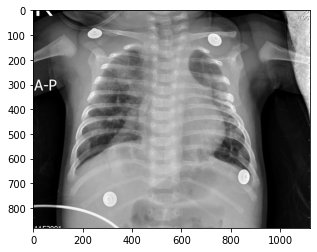

In [17]:
image = Image.open("/content/drive/MyDrive/Pneumonia/Pneumonia_data/data/test/VIR_PNEUMONIA/person1610_virus_2793.jpeg")
imshow(image, cmap="gray")

In [ ]:

data_to_tranform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
tensor = data_to_tranform(image)

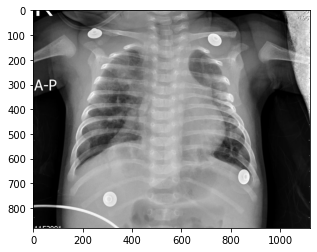

In [19]:
image = Image.open("/content/drive/MyDrive/Pneumonia/Pneumonia_data/data/test/VIR_PNEUMONIA/person1610_virus_2793.jpeg")
image = image.convert("RGB")
imshow(image)

In [48]:
 image = image.convert("RGB")
 data_to_tranform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
tensor = data_to_tranform(image)

In [49]:
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True) #!!!!

In [25]:
import torch

In [22]:
def create_model( number_of_classes = 3):#4 with unknown, but for v_01 - 3
        model = models.densenet121(pretrained=True)
        # Disable grad for all conv layers
        for param in model.parameters():
            param.requires_grad = False

        model.classifier = torch.nn.Linear(model.classifier.in_features, number_of_classes)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        return model

In [23]:
def load_model( path = "/content/drive/MyDrive/Pneumonia/state_dict_model.pt"):
        model = create_model()
        model.load_state_dict(torch.load(path))
        model.eval() 
        print(model.classifier)
        return model

In [26]:
model = load_model()

Linear(in_features=1024, out_features=3, bias=True)


In [27]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [50]:
final_layer = model.classifier

In [51]:
activated_features = SaveFeatures(final_layer)

In [52]:
prediction = model(prediction_var)

In [53]:
pred_probabilities = F.softmax(prediction).data.squeeze()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [54]:
activated_features.remove()

In [55]:
topk(pred_probabilities,1)

torch.return_types.topk(values=tensor([0.4914]), indices=tensor([2]))

In [56]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [57]:
weight_softmax_params = list(final_layer.parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())

In [58]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0877, -0.0419, -0.0232,  ..., -0.0128, -0.0502,  0.0310],
         [-0.0606,  0.0610,  0.0155,  ..., -0.0022,  0.0521, -0.0139],
         [ 0.1057, -0.0261,  0.0255,  ...,  0.0370, -0.0031, -0.0072]],
        requires_grad=True), Parameter containing:
 tensor([0.0074, 0.0048, 0.0063], requires_grad=True)]

In [59]:
class_idx = topk(pred_probabilities,1)[1].int()

In [45]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

ValueError: ignored

In [60]:
activated_features.features.shape

(1, 3)

In [ ]:
pip install pytorch-gradcam

In [ ]:
!pip install torchcam

In [67]:
from torchcam.cams import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

In [78]:
cam_extractor = SmoothGradCAMpp(model)

In [92]:
out = model(tensor.unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [94]:
out.squeeze(0).argmax().item()

2

In [95]:
out

tensor([[ 0.0657, -2.3221,  0.1192]], grad_fn=<AddmmBackward>)

In [93]:
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


AttributeError: ignored

In [79]:
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True) #!!!!
prediction = model(prediction_var)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1204: UserWarning: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is deprecated and will be forbidden starting version 1.6. You can remove this warning by cloning the output of the custom Function. (Triggered internally at  /pytorch/torch/csrc/autograd/variable.cpp:547.)
  result = torch.relu_(input)


In [80]:
prediction

tensor([[ 0.0657, -2.3221,  0.1192]], grad_fn=<AddmmBackward>)

In [81]:
activation_map = cam_extractor(prediction.squeeze(0).argmax().item(), prediction)

AttributeError: ignored

GRAD CAM

In [84]:
import gradcam

In [85]:
target_layer = model.classifier

In [ ]:
gradcam

In [90]:
gradcam =gradcam.GradCAM(model, target_layer)

NameError: ignored

HEAT MAP

In [ ]:
gradients = vgg.get_activations_gradient() model.g